# Notebbok for creating tables and plots for results

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import stats
import json
import random
from pprint import pprint
import re

from itertools import product, combinations
import importlib

from contextlib import redirect_stderr
import io
import sys
import os
import glob

from sklearn.metrics.pairwise import cosine_similarity
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from tqdm.auto import tqdm

AICOPE_PY_LIB = os.environ.get("AICOPE_PY_LIB")
if AICOPE_PY_LIB and AICOPE_PY_LIB not in sys.path: sys.path.append(AICOPE_PY_LIB)
import importlib
import aicnlp
importlib.reload(aicnlp)

%config Completer.use_jedi = False
PACSIM_DATA = os.environ.get("AICOPE_SCRATCH") + "/pacsim"

### Load data

In [2]:
from aicnlp import emb_mgr
importlib.reload(emb_mgr)

mgr = emb_mgr.EmbMgr("/workspace/scratch/pacsim/mgrdata")

In [3]:
from aicnlp.validation.agreement import get_data_all
importlib.reload(aicnlp.validation.agreement)
from aicnlp.validation.agreement import get_data_all

with open("/home/ubuntu/petr/similarity/validace/evaluation-response-20220907.json", encoding='utf-8') as f:
    valdata = json.load(f)

matmethods = ["Rrv2", "Rmms", "Reds"]
vmethods = ["Vlsa050", "Vlsa200", "Vrbc050", "Vrbc200", "Vd2v050", "Vd2v200"]

# matmethods = [ "Rmms",]
# vmethods = ["Vrbc200"]

annotations, mean_annotations, all_predictions, all_correlations = get_data_all(matmethods, vmethods, valdata, mgr)

  0%|          | 0/18 [00:00<?, ?it/s]

### Agreement boxplots

In [4]:
ctype_def = {
    "ann": "mean inter-annotator agreement",
    "all": "mean annotations vs. predictions from all notes",
    "cat": "mean annotations vs. predictions from category-specific notes"
}

category_def = { 
    "01": "01\nAge",
    "02": "02\nFamily\nhistory",
    "03": "03\nMedical\nhistory",
    "04": "04\nSocial\nhistory",
    "05": "05\nMedication",
    "06": "06\nAllergies",
    "07": "07\nTumor",
    "08": "08\nTreatment",
    "09": "09\nTreatment\ntype",
    "10": "10\nSide\neffects",
}

def latexify(text):
    return re.sub(
        r"\\background-color#([0-9a-f]*) \\color#([0-9a-f]*) (\S*)",
        r"\\cellcolor[HTML]{\1}{\\color[HTML]{\2} \3} ",
        text
    )

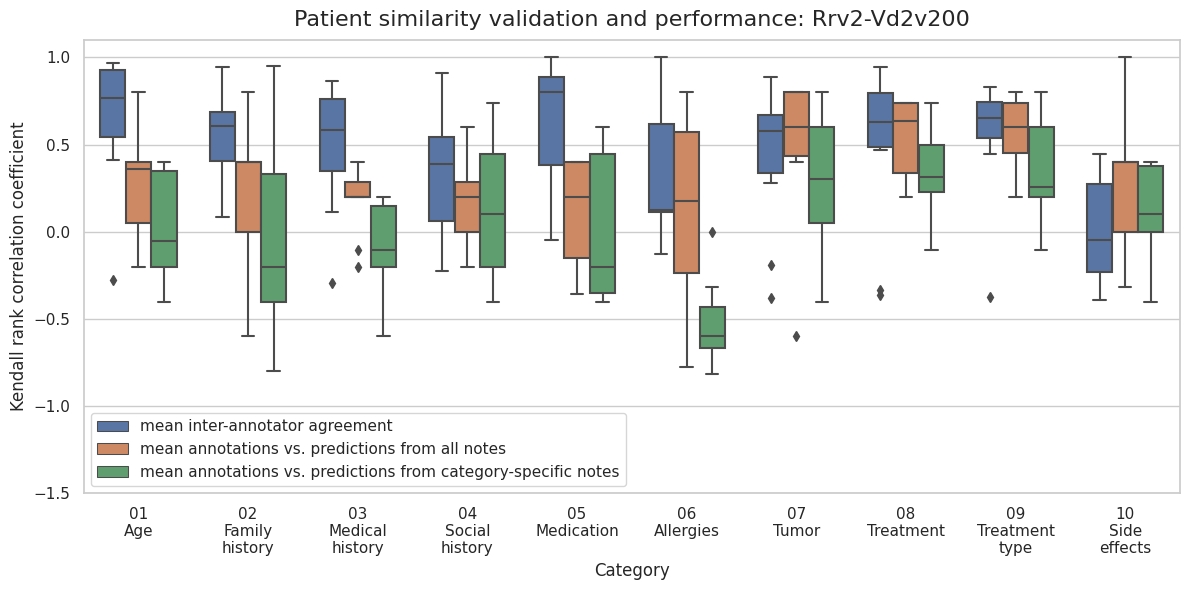

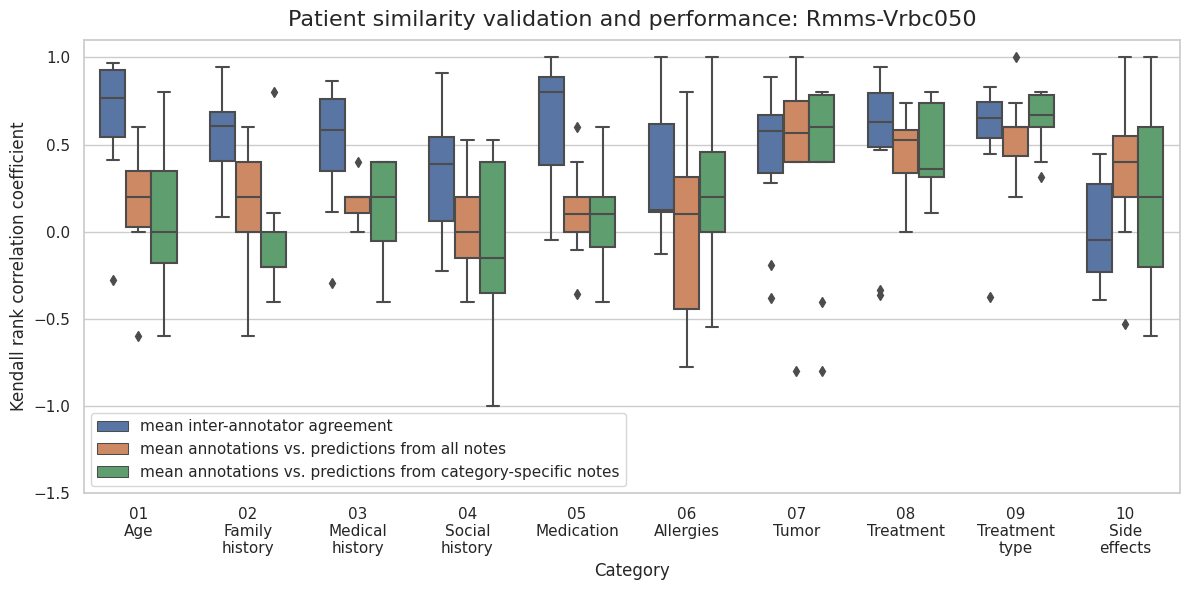

In [15]:
def validation_plot(matmethod, vmethod, all_correlations):
    correlations = all_correlations[matmethod, vmethod].copy()
    correlations["ctype"] = correlations["ctype"].map(ctype_def)
    correlations["cat"] = correlations["cat"].map(category_def)
    
    sns.set_theme(style="whitegrid", rc={'figure.figsize':(12, 6), 'axes.titlepad': 10})
    
    fig, ax = plt.subplots()
    plot = sns.boxplot(data=correlations, x="cat", y="value", hue="ctype", width=0.7, ax=ax)
    plot.set(
        ylim=(-1.5,1.1),
        xlabel="Category",
        ylabel="Kendall rank correlation coefficient",
    )
    plot.tick_params(axis="x", labelsize=11)
    plot.legend(
        title=None,
        loc='lower left',
        # bbox_to_anchor=(0.5, 1.10)
    )
    
    plot.set_title(f"Patient similarity validation and performance: {matmethod}-{vmethod}", fontsize=16)
    sns.reset_orig()
    return fig, plot


for method in ["Rrv2 Vd2v200", "Rmms Vrbc050"]:
    matmethod, vmethod = method.split()
    fig, plot = validation_plot(matmethod, vmethod, all_correlations)
    plt.tight_layout()
    fig.savefig(f"{PACSIM_DATA}/simvis/box2-{matmethod}-{vmethod}.pdf")
    plt.show(fig)
    plt.close(fig)

### Performance tables

In [24]:
def get_performance(all_correlations):
    performance = {}
    for (matmethod, vmethod), correlations in all_correlations.items():
        perf_cor = correlations.query("ctype != 'ann'").pivot_table(index = "ctype", columns=["cat"], values="value").round(3)
        perf_p = correlations.query("ctype != 'ann'").pivot_table(index = "ctype", columns=["cat"], values="pval", aggfunc=lambda x: (x <= 0.05).sum()/10).round(2)
        performance[matmethod, vmethod] = pd.concat([perf_cor,perf_p],axis=1,keys=['cor','p'])
    return pd.concat(performance, names=["matmethod", "vmethod"])

performance = get_performance(all_correlations)

In [68]:
def performance_table(performance, to_apply=lambda x: x.sort_values(("cor", "mean")), do_pivots=False):
    performance = performance.copy()
    nc = len(performance.columns)
    performance["cor", "mean"] = performance.iloc[:, :nc//2].mean(axis=1)
    performance["p", "mean"] = performance.iloc[:, nc//2:nc].mean(axis=1)
    # performance = performance.reset_index().reset_index(drop=True)
    pplus = performance.copy().reset_index()
    performance = to_apply(performance)
    ps = performance.style
    ps = ps.format("{:.2f}", subset=performance.columns[:])
    # ps = ps.background_gradient(axis=0, cmap="RdYlGn", vmin=0, vmax=1, subset=list(performance.columns[:nc//2])+[performance.columns[-2]])
    # ps = ps.background_gradient(axis=0, cmap="RdYlGn", vmin=0, vmax=10, subset=list(performance.columns[nc//2:nc])+[performance.columns[-1]])
    ps = ps.background_gradient(axis=0, cmap="RdYlGn", vmin=0, vmax=0.8)    
    # display(pplus.columns)
    pivots = None
    if do_pivots:
        pivots = pplus.pivot_table(index=[("matmethod", "")], columns=[("vmethod", ""), ("ctype", "")], values=[("cor", "mean")])
        pivots = pivots[[pivots.columns[i] for i in [4,5,6,7,0,1,2,3,8,9,10,11]]]
        pivots = pivots.iloc[[2,1,0]]
        pivots.index.name = None
        # pivots.columns.names = [(None, None), (None, None), None]
        pivots = pivots.style.format("{:.2f}").background_gradient(cmap="RdYlGn", vmin=0, vmax=0.3)
        # display(pivots)

    return ps, pivots
    
ps, pivots = performance_table(performance, to_apply=lambda x: x.sort_values(("cor", "mean")).iloc[:, list(range(10))+[-2]].iloc[::-1], do_pivots=True)
# ps, pivots = performance_table(performance, to_apply=lambda x: x.sort_values(("cor", "mean")).iloc[:, list(range(10, 20))+[-1]].iloc[::-1])
display(pivots)
ps
# :, list(range(5))+list(range(-10, 0))

In [58]:
text = latexify(pivots.to_latex())
text = re.sub(r"(R...|V......)", r"\\texttt{\1}", text)
text = re.sub(r"lllrrrrrrrrrrr", r"llc|cccccccccc|c", text)
text = re.sub(" &  &  & \\\\multicolumn\{11\}\{r\}\{cor\} \\\\\\\\\n", r"", text)
text = re.sub(r"&  & cat &", r"&  & filter &", text)
text = re.sub(r"cat", r"\\cmark", text)
text = re.sub(r"all", r"\\xmark", text)
text = re.sub("matmehod & vmethod & ctype &  &  &  &  &  &  &  &  &  &  &  \\\\\\\\\n", r"", text)
text = re.sub(r"\\\\", r"\\rule{0pt}{2.3ex}\\\\", text)

# print(text)

In [64]:
text = latexify(ps.to_latex(sparse_index=False))
text = re.sub(r"(R...|V......)", r"\\texttt{\1}", text)
text = re.sub(r"lllrrrrrrrrrrr", r"llc|cccccccccc|c", text)
text = re.sub(" &  &  & \\\\multicolumn\{11\}\{r\}\{cor\} \\\\\\\\\n", r"", text)
text = re.sub(r"&  & cat &", r"&  & filter &", text)
text = re.sub(r"cat", r"\\cmark", text)
text = re.sub(r"all", r"\\xmark", text)
text = re.sub("matmehod & vmethod & ctype &  &  &  &  &  &  &  &  &  &  &  \\\\\\\\\n", r"", text)
text = re.sub(r"\\\\", r"\\rule{0pt}{2.3ex}\\\\", text)

# print(text)

### Annotator as model

In [70]:
def annotator_as_model(batch):
    # batch=batch.reset_index(drop=True)
    # print(batch)
    anns = batch["ann"].unique()
    pivot = batch["pivot"].iloc[0]
    cat = batch["cat"].iloc[0]
    
    cors = []
    for a1, a2 in combinations(anns, 2):
        am =  list(set(anns) - set([a1, a2]))[0]
        s1 = batch[batch["ann"] == a1][["proxy", "value"]].set_index("proxy").sort_index()
        s2 = batch[batch["ann"] == a2][["proxy", "value"]].set_index("proxy").sort_index()
        sm = batch[batch["ann"] == am][["proxy", "value"]].set_index("proxy").sort_index()
        gt = s1+s2
        c,p = stats.kendalltau(gt, sm, alternative="greater")
        cors.append({
            "model": am,
            "vs": f"{a1}+{a2}",
            "value": c,
            "pval": p,
        })
        
        model = aasm_predictions[pivot, cat].set_index("proxy").sort_index()
        c,p = stats.kendalltau(gt, model, alternative="greater")
        cors.append({
            "model": aasm_model,
            "vs": f"{a1}+{a2}",
            "value": c,
            "pval": p,
        })
        

    return pd.DataFrame.from_records(cors)


def get_annotator_as_model(annotations):
    with redirect_stderr(io.StringIO()) as f:
        aasm = annotations.groupby(["pivot", "cat"]).apply(annotator_as_model).reset_index()
    aasm_cor = aasm.pivot_table(index=["model", "vs"], columns="cat", values="value").round(2)
    aasm_p = aasm.pivot_table(index=["model", "vs"], columns="cat", values="pval", aggfunc=lambda x: (x <= 0.05).sum()/10).round(2)
    aasm_perf = pd.concat([aasm_cor,aasm_p],axis=1,keys=['cor','p'])
    return aasm_perf


# aasm_model = "Rrv2-Vd2v200"
aasm_model = "Rmms-Vrbc200"
# aasm_model = "Rmms-Vlsa050"

# aasm_model = "Rmms-Vlsa200"
aasm_predictions = all_predictions[tuple(aasm_model.split("-"))]
aasm_predictions = dict(list(aasm_predictions.groupby(["pivot", "cat"])[["proxy", "value"]]))

aasm = get_annotator_as_model(annotations).sort_index(level="vs")
aasm = aasm[filter(lambda x: x[1] in "07 08 09".split(), aasm.columns)]
aasm_color, _ = performance_table(aasm, lambda x: x.sort_index(axis=1, level=0))
aasm_color

In [71]:
text = latexify(aasm_color.to_latex(hrules=True))
text = text.replace(r"\multicolumn{4}{r}{cor}", r"\multicolumn{4}{c|}{mean correlation}")
text = text.replace(r"\multicolumn{4}{r}{p}", r"\multicolumn{4}{c}{fraction of signifficant}")
text = text.replace(r"& cat &", r"& &")
text = text.replace("model & vs &  &  &  &  &  &  &  &  \\\\\n", r"")
text = text.replace(r"a3", r"a1")
text = text.replace(r"a4", r"a2")
text = text.replace(r"a6", r"a3")
text = text.replace(r"llrrrrrrrr", r"ll|rrrr|rrrr")
text = text.replace(r"Rmms-Vrbc200", r"our")
text = re.sub(r"\\\\", r"\\rule{0pt}{2.3ex}\\\\", text)
print(text)

\begin{tabular}{ll|rrrr|rrrr}
\toprule
 &  & \multicolumn{4}{c|}{mean correlation} & \multicolumn{4}{c}{fraction of signifficant} \rule{0pt}{2.3ex}\\
 & & 07 & 08 & 09 & mean & 07 & 08 & 09 & mean \rule{0pt}{2.3ex}\\
\midrule
our & a1+a2 & \cellcolor[HTML]{feffbe}{\color[HTML]{000000} 0.40}  & \cellcolor[HTML]{ddf191}{\color[HTML]{000000} 0.47}  & \cellcolor[HTML]{9dd569}{\color[HTML]{000000} 0.57}  & \cellcolor[HTML]{d9ef8b}{\color[HTML]{000000} 0.48}  & \cellcolor[HTML]{feffbe}{\color[HTML]{000000} 0.40}  & \cellcolor[HTML]{fed27f}{\color[HTML]{000000} 0.30}  & \cellcolor[HTML]{fed27f}{\color[HTML]{000000} 0.30}  & \cellcolor[HTML]{fee593}{\color[HTML]{000000} 0.33}  \rule{0pt}{2.3ex}\\
a3 & a1+a2 & \cellcolor[HTML]{48ae5c}{\color[HTML]{f1f1f1} 0.67}  & \cellcolor[HTML]{9dd569}{\color[HTML]{000000} 0.57}  & \cellcolor[HTML]{b9e176}{\color[HTML]{000000} 0.53}  & \cellcolor[HTML]{8ecf67}{\color[HTML]{000000} 0.59}  & \cellcolor[HTML]{87cb67}{\color[HTML]{000000} 0.60}  & \cellcolor[HTM